In [58]:
# check for cuda
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import time
import copy
import argparse
import ast
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from scipy.sparse import lil_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
# check for cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [59]:
# Load the CSV file and extract the Description column
data = pd.read_csv('ANLP-2/train.csv')
corpus = data['Description']
sentence_count= 0
sentence_limit = 40000
sentences_list = []

for sentence in corpus:
    sentences_list.append(sentence)
    sentence_count += 1
    if sentence_count > sentence_limit:
        break

word_counts = {}
text_courpus = []
MinWords = 40000 # min words in a sentence
minSentenceLength = 500 # min words in a sentence
maxSenteceLength = 0 # max words in a sentence
for sentence in sentences_list:
    sentence = sentence.lower() # convert to lower case
    sentence = re.sub(r'[^\w\s]', '', sentence) # remove punctuation
    text_courpus.append(sentence)
    words = sentence.split()
    minSentenceLength = min(minSentenceLength, len(words))
    maxSenteceLength = max(maxSenteceLength, len(words))
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1


Go with words if freq is > 1

In [60]:
len(text_courpus)


40001

### Creating Word embedding 

In [61]:
class WordEmbedding:
    def __init__(self, window_size=2, embedding_size=100):
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.word2index = {}
        self.index2word = {}
        self.word_counts = {}
        self.word_vectors = None
        self.word_vectors_norm = None
        self.vocab_size = 0
    def buid_Co_occurence_matrix(self, corpus, word_counts):
        self.word2index = {word: i for i, word in enumerate(word_counts.keys())}
        self.index2word = {i: word for word, i in self.word2index.items()}
        self.word_counts = word_counts
        self.corpus = corpus
        vocab = set(word_counts.keys())
        self.vocab_size = len(vocab)
        #Create a n*n matrix where n is the number of words in the vocab
        self.co_occurence_matrix = lil_matrix((self.vocab_size, self.vocab_size), dtype=np.float32)
        for sentence in corpus:
            words = sentence.split()
            for i, word in enumerate(words):
                if word in self.word2index:
                    for j in range(max(i - self.window_size, 0), min(i + self.window_size, len(words))):
                        if i != j and words[j] in self.word2index:
                            self.co_occurence_matrix[self.word2index[word], self.word2index[words[j]]] += 1
    
    def train(self, corpus, word_counts):
        self.buid_Co_occurence_matrix(corpus, word_counts)
        svd = TruncatedSVD(n_components=self.embedding_size)
        svd.fit(self.co_occurence_matrix)
        embeddings = svd.components_
        embeddings = np.transpose(embeddings)
        return embeddings, self.word2index, self.index2word
    


In [62]:
%%time
Embedding_Model = WordEmbedding(window_size=3, embedding_size=100)
embeddings, word2index, index2word = Embedding_Model.train(text_courpus, word_counts)

CPU times: user 1min 22s, sys: 50.3 s, total: 2min 12s
Wall time: 48.4 s


In [85]:
U, s, VT = np.linalg.svd(embeddings, full_matrices = False)

In [86]:
U

array([[-0.22213003,  0.02892269,  0.07085911, ...,  0.06013289,
        -0.08541614,  0.6771826 ],
       [ 0.00052272,  0.00025877, -0.00015455, ..., -0.00022449,
        -0.00011904, -0.00042969],
       [ 0.13379152,  0.18733609,  0.11225141, ..., -0.32770628,
        -0.50570583, -0.03377211],
       ...,
       [-0.00000244, -0.00000249, -0.00000615, ..., -0.0000081 ,
        -0.00000144, -0.00000163],
       [ 0.00006544,  0.00016421, -0.00001617, ..., -0.00006515,
         0.00011846, -0.00002497],
       [-0.00004395,  0.00007082,  0.00019428, ..., -0.00003278,
        -0.00002571, -0.0001171 ]], dtype=float32)

In [87]:
s

array([1.0000128 , 1.0000101 , 1.0000088 , 1.0000066 , 1.000006  ,
       1.000004  , 1.0000026 , 1.0000021 , 1.000002  , 1.0000014 ,
       1.0000012 , 1.0000011 , 1.000001  , 1.0000008 , 1.0000008 ,
       1.0000008 , 1.0000008 , 1.0000007 , 1.0000007 , 1.0000007 ,
       1.0000007 , 1.0000006 , 1.0000006 , 1.0000006 , 1.0000006 ,
       1.0000005 , 1.0000005 , 1.0000005 , 1.0000005 , 1.0000005 ,
       1.0000004 , 1.0000004 , 1.0000004 , 1.0000004 , 1.0000004 ,
       1.0000004 , 1.0000002 , 1.0000002 , 1.0000002 , 1.0000002 ,
       1.0000002 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999998 , 0.9999998 , 0.9999998 ,
       0.99999976, 0.99999976, 0.99999976, 0.9999997 , 0.9999997 ,
       0.9999997 , 0.99999964, 0.99999964, 0.99999964, 0.99999

In [88]:
VT

array([[-0.26232737, -0.00970989,  0.11289898, ...,  0.06295528,
         0.05262546,  0.02915944],
       [ 0.46669644,  0.01345092,  0.3083488 , ...,  0.08336537,
         0.02488412, -0.00644897],
       [-0.268759  , -0.0080764 ,  0.49353808, ...,  0.0733855 ,
         0.03616012,  0.06865296],
       ...,
       [ 0.06084326, -0.00128059, -0.34012598, ..., -0.04796411,
        -0.08628707, -0.03956963],
       [-0.05872356,  0.00005796, -0.3103516 , ..., -0.06887907,
        -0.07642335, -0.05503322],
       [ 0.41490263,  0.00348486, -0.00629473, ..., -0.0058021 ,
         0.01568688,  0.00026806]], dtype=float32)

In [89]:
U_df=pd.DataFrame(U,index=word2index.keys())
U_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
reuters,-0.222130,0.028923,0.070859,0.063975,-0.083826,7.256947e-02,0.123918,-0.152987,4.019501e-02,-0.092436,...,8.875142e-03,-5.089399e-02,0.126147,-0.075065,6.533650e-02,1.263432e-01,-0.009819,0.060133,-0.085416,0.677183
shortsellers,0.000523,0.000259,-0.000155,-0.000492,-0.000014,4.384294e-04,0.001126,0.000012,1.806675e-04,0.000119,...,-7.790676e-05,-1.832452e-04,-0.000738,0.000705,-1.829061e-04,3.000643e-05,-0.000200,-0.000224,-0.000119,-0.000430
wall,0.133792,0.187336,0.112251,-0.048853,-0.014927,2.091221e-02,0.204112,-0.064213,7.249253e-03,0.062833,...,5.423813e-02,6.339888e-02,-0.027272,-0.078467,1.026155e-02,1.384958e-02,0.019838,-0.327706,-0.505706,-0.033772
streets,-0.005925,0.008940,-0.004703,-0.000327,-0.001971,-1.848630e-03,0.015305,-0.013855,-2.219643e-03,-0.004063,...,-3.594295e-03,-7.806592e-04,-0.003059,0.009936,-3.341110e-04,7.807426e-05,0.003827,0.002705,-0.000566,-0.003918
dwindlingband,-0.000016,0.000127,-0.000023,-0.000147,-0.000063,7.196661e-06,0.000525,-0.000119,-1.852069e-04,0.000081,...,-1.125397e-04,-1.193534e-04,-0.000169,0.000414,1.247913e-04,-5.367392e-05,0.000064,-0.000015,-0.000084,-0.000059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ziadi,0.000123,0.000204,-0.000038,0.000143,0.000029,-1.131241e-04,0.000086,0.000099,6.936770e-05,-0.000018,...,1.274097e-04,-1.151994e-04,0.000045,0.000090,2.798725e-04,6.542784e-05,-0.000034,0.000062,0.000139,-0.000016
bestseller,0.000047,0.000054,0.000049,-0.000001,0.000099,-8.421094e-05,-0.000136,0.000014,3.364060e-05,-0.000052,...,-3.919391e-05,7.977790e-05,0.000045,-0.000102,-4.634376e-05,-3.816720e-05,-0.000030,-0.000015,0.000019,0.000039
unanimouscoward,-0.000002,-0.000002,-0.000006,0.000002,0.000001,4.238149e-07,0.000003,0.000005,4.695991e-07,0.000002,...,-4.899270e-07,-4.542973e-07,0.000004,-0.000003,3.747418e-07,-1.195573e-07,-0.000006,-0.000008,-0.000001,-0.000002
39censorship,0.000065,0.000164,-0.000016,0.000085,0.000035,-1.142987e-05,-0.000047,-0.000117,9.071405e-05,-0.000087,...,-3.358871e-05,1.626713e-04,0.000038,0.000050,-2.739781e-05,6.951381e-05,0.000043,-0.000065,0.000118,-0.000025


### Plot the similar words

In [93]:
%%time

def plot_similar_words(input_word, word2index, embeddings):
    input_word_index = word2index[input_word]
    input_word_embedding = embeddings[input_word_index]
    print('Word vector for the word:', input_word)
    print(input_word_embedding)
    
    word_distances = []
    for word, idx in word2index.items():
        if word == input_word:
            continue
        other_word_embedding = embeddings[idx]
        distance = np.linalg.norm(input_word_embedding - other_word_embedding)
        word_distances.append([word, distance, other_word_embedding])
    
    word_distances.sort(key=lambda x: x[1])
    closest_embeddings = []
    word_labels = []
    print('Top 10 similar words to the input word:', input_word)
    for i in range(10):
        print(word_distances[i][0])
        closest_embeddings.append(word_distances[i][2])
        word_labels.append(word_distances[i][0])
    
    tsne = TSNE(n_components=2, random_state=0, perplexity=5)
    np.set_printoptions(suppress=True)
    y = tsne.fit_transform(np.asarray(closest_embeddings))
    x_coords = y[:, 0]
    y_coords = y[:, 1]
    
    plt.figure(figsize=(10, 8))
    plt.scatter(x_coords, y_coords, marker='o', color='blue', label='Similar Words')
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.title('Similar Words Visualization')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


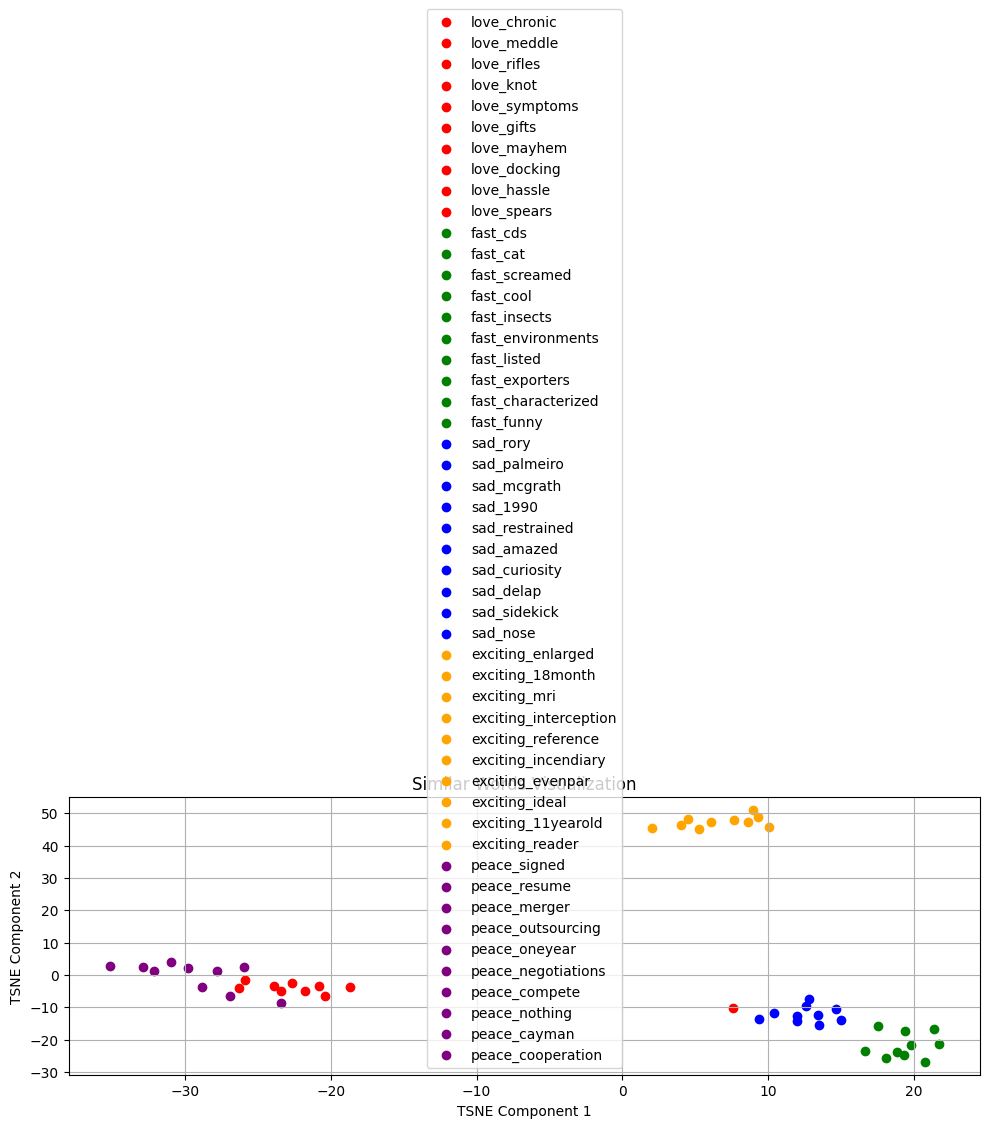

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_similar_words(input_words, word2index, embeddings):
    closest_embeddings = []
    word_labels = []
    word_colors = []
    
    # Define a color map for each input word
    color_map = {
        'love': 'red',
        'fast': 'green',
        'sad': 'blue',
        'exciting': 'orange',
        'peace': 'purple'
    }
    
    for input_word in input_words:
        input_word_index = word2index[input_word]
        input_word_embedding = embeddings[input_word_index]
        word_distances = []
        
        for word, idx in word2index.items():
            if word == input_word:
                continue
            other_word_embedding = embeddings[idx]
            distance = np.linalg.norm(input_word_embedding - other_word_embedding)
            word_distances.append([word, distance, other_word_embedding])
        
        word_distances.sort(key=lambda x: x[1])
        for i in range(10):
            closest_embeddings.append(word_distances[i][2])
            word_labels.append(f'{input_word}_{word_distances[i][0]}')
            word_colors.append(color_map[input_word])  # Assign color based on input word
    
    tsne = TSNE(n_components=2, random_state=0, perplexity=5)
    np.set_printoptions(suppress=True)
    y = tsne.fit_transform(np.asarray(closest_embeddings))
    x_coords = y[:, 0]
    y_coords = y[:, 1]
    
    plt.figure(figsize=(10, 8))
    
    # Plot each point with its assigned color
    for label, x, y, color in zip(word_labels, x_coords, y_coords, word_colors):
        plt.scatter(x, y, marker='o', color=color, label=label)
    
    plt.title('Similar Words Visualization')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage for 5 different words
input_words = ['love', 'fast', 'sad', 'exciting', 'peace']
plot_similar_words(input_words, word2index, embeddings)


Word vector for the word: love
[ 0.00055015  0.00020144  0.00041482  0.00088471  0.00045299 -0.00098084
 -0.00072094  0.00096693  0.00020105  0.00052364  0.00074464  0.00022947
 -0.00048349  0.0001961  -0.00090087 -0.00041445 -0.00040789  0.00013042
  0.0005095   0.00024119  0.00067874  0.00025918  0.00056193 -0.00056333
 -0.00079116 -0.00091696 -0.00006172 -0.00035488  0.00106201  0.00058411
  0.00065546  0.00044031  0.0012946   0.00069807 -0.00140769  0.0007604
 -0.00180124  0.00008097 -0.00064616 -0.00039761 -0.00043364 -0.00134598
 -0.00142453  0.00145995 -0.00312889  0.00103079 -0.00004938 -0.00248446
  0.00140737 -0.00000479  0.00126307  0.00122321 -0.00319658  0.00137111
 -0.00153568 -0.00171107 -0.00023164 -0.00200536  0.00167685 -0.00173251
  0.00436215 -0.00248796  0.00074133  0.00048852 -0.00230335 -0.00249012
 -0.00245701 -0.00152293  0.00128665  0.00304812 -0.0027864  -0.00315149
 -0.00022183  0.00002581  0.00205044  0.00151931 -0.00177814 -0.00268223
 -0.0002544   0.00247

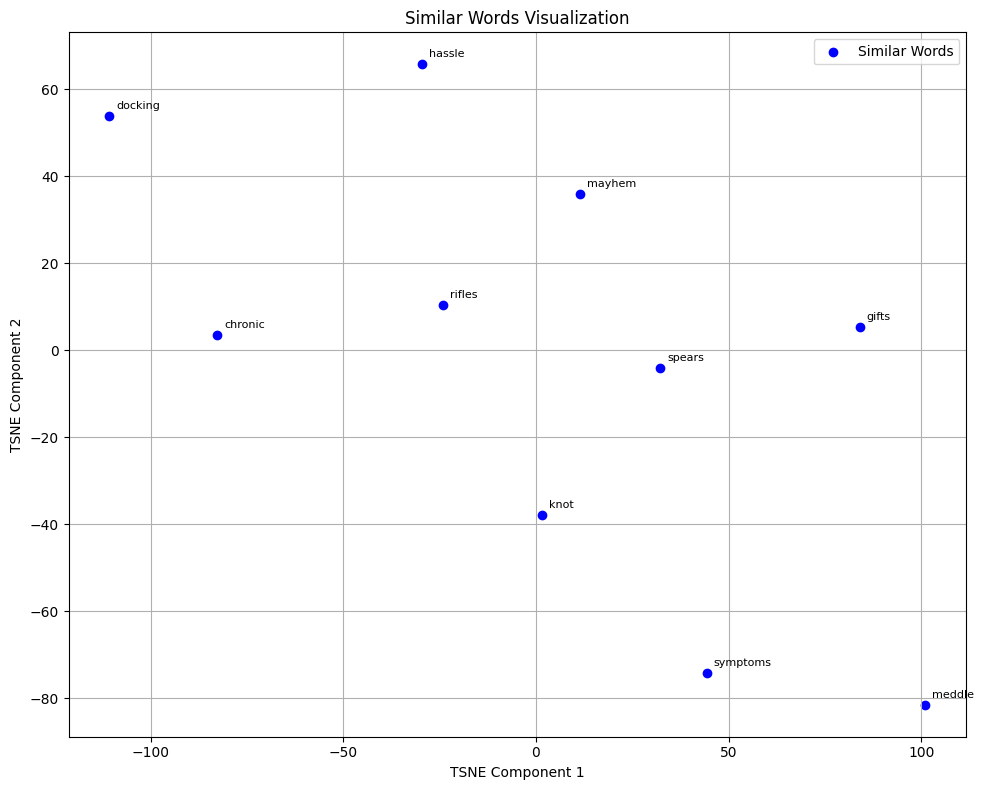

CPU times: user 1.15 s, sys: 231 ms, total: 1.38 s
Wall time: 330 ms


In [94]:
%%time

# PRONOUN ANALYSIS

plot_similar_words('love', word2index, embeddings)

Word vector for the word: great
[ 0.00315503  0.00151877  0.00018798 -0.00155086  0.0048697  -0.00431101
 -0.00176101  0.003596    0.0011254   0.00112021 -0.00043951  0.00062726
  0.00568472  0.00542755 -0.00539417 -0.00045032  0.00527873 -0.00015879
 -0.00038156  0.00054156  0.00617934 -0.00172981 -0.00173569 -0.00201612
 -0.00157647 -0.00169865 -0.00206472 -0.0024215   0.0015446  -0.00016877
  0.00049922  0.0023232  -0.00320138 -0.00465262 -0.00424063  0.00761318
  0.00136843  0.00202925 -0.00398565 -0.00187633  0.01279956 -0.00058813
 -0.00092522  0.00173981 -0.00874614  0.00372295  0.00741006 -0.00717906
  0.00591374 -0.00413951  0.0093738   0.00721716  0.0030751  -0.01107339
 -0.0023837   0.0016031  -0.0076385   0.01502806 -0.00674118  0.00554552
 -0.0085762  -0.00208885  0.00204609  0.00143486 -0.00627537 -0.00884188
 -0.00579838 -0.00626508 -0.00228924 -0.00595887 -0.00438855  0.00218205
 -0.0020478   0.00511878  0.0000203  -0.00609049  0.0080798  -0.00907264
 -0.00259701  0.009

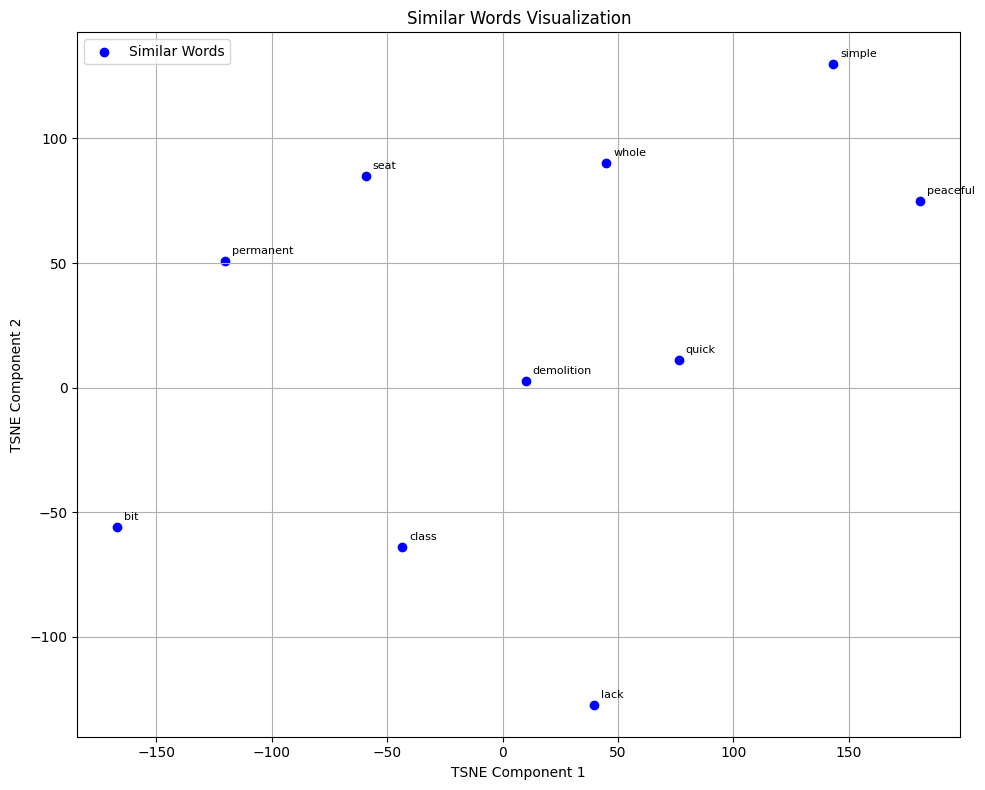

CPU times: user 1.15 s, sys: 240 ms, total: 1.39 s
Wall time: 345 ms


In [97]:
%%time

plot_similar_words('great', word2index, embeddings)

Word vector for the word: natural
[ 0.00087516 -0.00006909 -0.00027437 -0.00093655  0.00078075 -0.00131979
  0.00039791  0.00052685  0.00040735 -0.00137882  0.00244162  0.00044016
  0.00217447  0.0057412   0.00687068 -0.00002147  0.00009836 -0.00460936
 -0.00708717  0.00110774  0.00021587 -0.00047631 -0.00300341 -0.00567894
 -0.00079623 -0.00008183  0.00123708 -0.00035426 -0.00106132  0.00560241
 -0.0059648   0.00245879 -0.00095361 -0.00133515  0.00821145  0.00587489
 -0.00604158  0.00362205  0.00113982 -0.00127352  0.00153234 -0.00380522
 -0.00719891 -0.00191177  0.00004481  0.00254332 -0.00055424  0.00381989
  0.00095138  0.00386775 -0.0015299  -0.00071073 -0.00314524 -0.00409933
  0.00016626  0.00045848  0.00187115 -0.00020492 -0.00041839  0.00393212
 -0.00424204 -0.00240829  0.00037077 -0.00378353  0.00309073  0.00172366
 -0.00314696 -0.00183247 -0.00039988 -0.0017389  -0.00312188 -0.00001469
 -0.00284366 -0.0064549   0.00078622  0.00310137  0.00267851 -0.00155178
  0.00034086  0.0

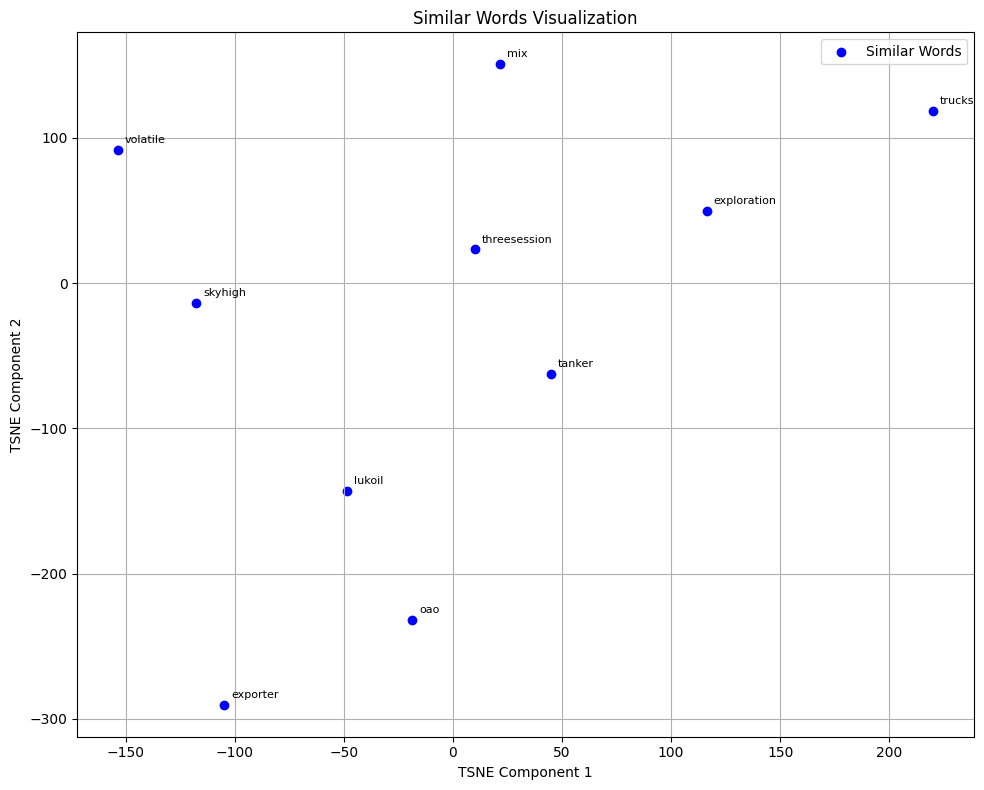

In [100]:
plot_similar_words('natural', word2index, embeddings)

### Saving the embeddings

In [82]:
import json
word_embeddings_tensor = torch.FloatTensor(embeddings)
# Save the embeddings to a file
torch.save(word_embeddings_tensor, 'svd-word-vectors.pt')
# Save word2index and index2word to JSON files
def save_dictionary(dictionary, file_path):
    with open(file_path, 'w') as f:
        json.dump(dictionary, f)

# Load word2index and index2word from JSON files

# Save dictionaries to JSON files
save_dictionary(word2index, 'word2index.json')
save_dictionary(index2word, 'index2word.json')



In [75]:
# Load the embeddings from the saved file
import json
word_embeddings = torch.load('svd-word-vectors.pt')
# Load dictionaries from JSON files
def load_dictionary(file_path):
    with open(file_path, 'r') as f:
        dictionary = json.load(f)
    return dictionary
word2index = load_dictionary('word2index.json')
index2word = load_dictionary('index2word.json')

### Now classification task

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [77]:
%%time
num_sentences = 40001
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(word_embeddings), freeze=True)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Multiply by 2 for bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.bilstm(embedded)
        logits = self.fc(lstm_out[:, -1, :])  # Take last timestep's output
        return logits

 
learning_rate = 0.001
# Initialize the model and move it to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMClassifier(embedding_dim=100, hidden_dim=128, num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 5
data = pd.read_csv('ANLP-2/train.csv')
class_indices_40000 = data['Class Index'][:num_sentences]

# for epoch in range(num_epochs):
#     model.train()  # Set the model to training mode
#     total_loss = 0
#     correct_predictions = 0
#     total_samples = 0

#     for idx in range(len(text_courpus)):
#         word_tokens = text_courpus[idx].split()
#         # Convert words to indices and then to tensor
#         word_indices = [word2index[word] for word in word_tokens if word in word2index]
#         word_tensor = torch.LongTensor(word_indices).unsqueeze(0).to(device)
#         # Get the class label
#         class_label = class_indices_40000[idx]
#         class_tensor = torch.LongTensor([class_label]).to(device)

#         outputs = model(word_tensor)
        
#         loss = criterion(outputs, class_tensor)
#         optimizer.zero_grad()  # Clear gradients
#         outputs = model(word_tensor)  # Forward pass
#         loss = criterion(outputs, class_tensor)  # Compute loss

#         loss.backward()  # Backpropagation
#         optimizer.step()  # Update weights

#         total_loss += loss.item()

#         # Compute accuracy
#         _, predicted = torch.max(outputs, 1)
#         correct_predictions += (predicted == class_tensor).sum().item()
#         total_samples += 1


#     epoch_loss = total_loss / total_samples
#     epoch_accuracy = correct_predictions / total_samples

#     print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define lists to store metrics for train set
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []
train_confusion_matrices = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    y_true = []  # True labels
    y_pred = []  # Predicted labels

    for idx in range(len(text_courpus)):
        word_tokens = text_courpus[idx].split()
        # Convert words to indices and then to tensor
        word_indices = [word2index[word] for word in word_tokens if word in word2index]
        word_tensor = torch.LongTensor(word_indices).unsqueeze(0).to(device)
        # Get the class label
        class_label = class_indices_40000[idx]
        class_tensor = torch.LongTensor([class_label]).to(device)

        outputs = model(word_tensor)
        
        loss = criterion(outputs, class_tensor)
        optimizer.zero_grad()  # Clear gradients
        outputs = model(word_tensor)  # Forward pass
        loss = criterion(outputs, class_tensor)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == class_tensor).sum().item()
        total_samples += 1
        
        # Append true labels and predicted labels for metrics calculation
        y_true.append(class_tensor.item())
        y_pred.append(predicted.item())

    # Calculate training metrics after each epoch
    epoch_loss = total_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    # Calculate precision, recall, f1 score, and confusion matrix
    train_precision = precision_score(y_true, y_pred, average='macro')
    train_precisions.append(train_precision)
    
    train_recall = recall_score(y_true, y_pred, average='macro')
    train_recalls.append(train_recall)
    
    train_f1 = f1_score(y_true, y_pred, average='macro')
    train_f1_scores.append(train_f1)
    
    train_conf_matrix = confusion_matrix(y_true, y_pred)
    train_confusion_matrices.append(train_conf_matrix)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}')

    

/home/lokesh/path/to/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5, Loss: 1.1073, Accuracy: 0.5010, Precision: 0.3975, Recall: 0.3989, F1 Score: 0.3964
Epoch 2/5, Loss: 0.7359, Accuracy: 0.7085, Precision: 0.7040, Recall: 0.7067, F1 Score: 0.7045
Epoch 3/5, Loss: 0.5979, Accuracy: 0.7807, Precision: 0.7793, Recall: 0.7798, F1 Score: 0.7788
Epoch 4/5, Loss: 0.5448, Accuracy: 0.8034, Precision: 0.8025, Recall: 0.8028, F1 Score: 0.8021
Epoch 5/5, Loss: 0.5056, Accuracy: 0.8172, Precision: 0.8164, Recall: 0.8166, F1 Score: 0.8160
CPU times: user 13min 34s, sys: 9.01 s, total: 13min 43s
Wall time: 13min 59s


In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, criterion, test_corpus, test_class_indices, word2index, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for idx in range(len(test_corpus)):
            word_tokens = test_corpus[idx].split()
            if not word_tokens:
                continue
            # Convert words to indices and then to tensor
            word_indices = [word2index[word] for word in word_tokens if word in word2index]
            if not word_indices:  # Handle case where all words are out-of-vocabulary
                continue
            word_tensor = torch.LongTensor(word_indices).unsqueeze(0).to(device)
            # Get the class label
            class_label = test_class_indices[idx]
            class_tensor = torch.LongTensor([class_label]).to(device)

            outputs = model(word_tensor)
            
            loss = criterion(outputs, class_tensor)

            total_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == class_tensor).sum().item()
            total_samples += 1

            all_predictions.append(predicted.item())
            all_targets.append(class_label)

    epoch_loss = total_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples

    # Compute additional metrics
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=1)  # Set zero_division to 1
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=1)  # Set zero_division to 1
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=1)  # Set zero_division to 1
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    print(f'Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_accuracy:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)

# Example usage:
# Assuming you have 'model', 'criterion', 'word2index', 'device', 'test_corpus', and 'test_class_indices' already defined
evaluate_model(model, criterion, test_corpus, test_class_indices, word2index, device)


Test Loss: 0.8501, Test Accuracy: 0.6704
Precision: 0.6816, Recall: 0.6704, F1 Score: 0.6650
Confusion Matrix:
[[1016  410  273  201]
 [  76 1638   85  101]
 [ 101  168 1368  263]
 [  98  239  489 1070]]


In [81]:
torch.save(model.state_dict(), 'svd-classification-model.pt')